### Import Libraries

In [ ]:
import pandas as pd

### Import data 

In [2]:
investing_data_path = "data/raw/investing_data.xlsx"
zf_data_path = "data/raw/zf.csv"

investing_data = pd.ExcelFile(investing_data_path)
ppi_data = investing_data.parse('ppi')
unemployment_data = investing_data.parse('unemployment')
cpi_data = investing_data.parse('core_cpi')
fed_rates_data = investing_data.parse('fed_int_rate')

# Load ZF futures data
zf_data = pd.read_csv(zf_data_path)
zf_data.head()

,date,open,high,low,close,volume
0,2010-01-04,114.250000,114.632812,114.062500,114.546875,295473
1,2010-01-05,114.609375,115.007812,114.593750,114.945312,393545
2,2010-01-06,114.882812,114.929688,114.640625,114.906250,473208
3,2010-01-07,114.820312,114.929688,114.578125,114.796875,357551
4,2010-01-08,114.734375,115.195312,114.554688,115.007812,357551


In [3]:
## Standardize Dates
for df in [ppi_data, unemployment_data, cpi_data, fed_rates_data]:
    df['Release Date'] = pd.to_datetime(df['Release Date'])
    df.columns = ['date','time','actual','forecast','previous']

# Convert ZF data date column to datetime
zf_data['date'] = pd.to_datetime(zf_data['date'])


In [4]:
ppi_data

,date,time,actual,forecast,previous
0,2025-01-14,08:30:00,NaN,0.003,0.004
1,2024-12-12,08:30:00,0.004,0.002,0.003
2,2024-11-14,08:30:00,0.002,0.002,0.001
3,2024-10-11,07:30:00,0.000,0.001,0.002
4,2024-09-12,07:30:00,0.002,0.001,0.000
...,...,...,...,...,...
175,2010-06-16,07:30:00,-0.003,-0.005,-0.001
176,2010-05-18,07:30:00,-0.001,0.001,0.007
177,2010-04-22,07:30:00,0.007,0.004,-0.006
178,2010-03-17,07:30:00,-0.006,-0.002,0.014


### Feature Engineering 

In [5]:
# Create new features for deviations and percentage changes
def add_deviation_features(df,prefix=""):
    df[f'{prefix}_actual'] = pd.to_numeric(df['actual'], errors='coerce')
    df[f'{prefix}_forecast'] = pd.to_numeric(df['forecast'], errors='coerce')
    df[f'{prefix}_previous'] = pd.to_numeric(df['previous'], errors='coerce')
    df[f'{prefix}_dev_forecast'] = df[f'{prefix}_actual'] - df[f'{prefix}_forecast']
    df[f'{prefix}_dev_previous'] = df[f'{prefix}_actual'] - df[f'{prefix}_previous']
    df[f'{prefix}_pct_deviation_forecast'] = (df[f'{prefix}_dev_previous'] / df[f'{prefix}_forecast']) * 100
    df = df.drop(['time','actual','forecast','previous'], axis=1) 
    return df

ppi_data = add_deviation_features(ppi_data,prefix='ppi')
unemployment_data = add_deviation_features(unemployment_data,prefix='unemployment')
cpi_data = add_deviation_features(cpi_data,prefix='cpi')
fed_rates_data = add_deviation_features(fed_rates_data,prefix='interest_rates')


In [6]:
fed_rates_data

,date,interest_rates_actual,interest_rates_forecast,interest_rates_previous,interest_rates_dev_forecast,interest_rates_dev_previous,interest_rates_pct_deviation_forecast
0,2024-12-18,0.0450,0.0450,0.0475,0.0000,-0.0025,-5.555556
1,2024-11-07,0.0475,0.0475,0.0500,0.0000,-0.0025,-5.263158
2,2024-09-18,0.0500,0.0525,0.0550,-0.0025,-0.0050,-9.523810
3,2024-07-31,0.0550,0.0550,0.0550,0.0000,0.0000,0.000000
4,2024-06-12,0.0550,0.0550,0.0550,0.0000,0.0000,0.000000
...,...,...,...,...,...,...,...
125,2009-06-24,0.0025,0.0025,0.0025,0.0000,0.0000,0.000000
126,2009-04-29,0.0025,0.0025,0.0025,0.0000,0.0000,0.000000
127,2009-03-18,0.0025,0.0025,0.0025,0.0000,0.0000,0.000000
128,2009-01-28,0.0025,0.0025,0.0025,0.0000,0.0000,0.000000


In [7]:
zf_data = zf_data.merge(ppi_data, how='left',on='date')
zf_data = zf_data.merge(unemployment_data, how='left',on='date')
zf_data = zf_data = zf_data.merge(cpi_data, how='left',on='date')
zf_data = zf_data.merge(fed_rates_data, how='left',on='date')

In [8]:
zf_data.head()

,date,open,high,low,close,volume,ppi_actual,ppi_forecast,ppi_previous,ppi_dev_forecast,...,cpi_previous,cpi_dev_forecast,cpi_dev_previous,cpi_pct_deviation_forecast,interest_rates_actual,interest_rates_forecast,interest_rates_previous,interest_rates_dev_forecast,interest_rates_dev_previous,interest_rates_pct_deviation_forecast
0,2010-01-04,114.250000,114.632812,114.062500,114.546875,295473,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,114.609375,115.007812,114.593750,114.945312,393545,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-06,114.882812,114.929688,114.640625,114.906250,473208,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-07,114.820312,114.929688,114.578125,114.796875,357551,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-08,114.734375,115.195312,114.554688,115.007812,357551,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
zf_data.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'ppi_actual',
       'ppi_forecast', 'ppi_previous', 'ppi_dev_forecast', 'ppi_dev_previous',
       'ppi_pct_deviation_forecast', 'unemployment_actual',
       'unemployment_forecast', 'unemployment_previous',
       'unemployment_dev_forecast', 'unemployment_dev_previous',
       'unemployment_pct_deviation_forecast', 'cpi_actual', 'cpi_forecast',
       'cpi_previous', 'cpi_dev_forecast', 'cpi_dev_previous',
       'cpi_pct_deviation_forecast', 'interest_rates_actual',
       'interest_rates_forecast', 'interest_rates_previous',
       'interest_rates_dev_forecast', 'interest_rates_dev_previous',
       'interest_rates_pct_deviation_forecast'],
      dtype='object')

ZF Data Summary:
             close  ppi_dev_forecast  unemployment_dev_forecast  \
count  3730.000000        177.000000                 173.000000   
mean    118.103921          0.000051                  -0.001029   
std       5.559233          0.002982                   0.005354   
min     103.921875         -0.008000                  -0.064000   
25%     114.800781         -0.002000                  -0.001000   
50%     119.335938          0.000000                   0.000000   
75%     121.779297          0.002000                   0.001000   
max     126.210938          0.010000                   0.006000   

       cpi_dev_forecast  interest_rates_dev_forecast  
count        176.000000                 1.170000e+02  
mean          -0.000011                 5.930679e-20  
std            0.001166                 3.282661e-04  
min           -0.003000                -2.500000e-03  
25%           -0.001000                 0.000000e+00  
50%            0.000000                 0.000000e

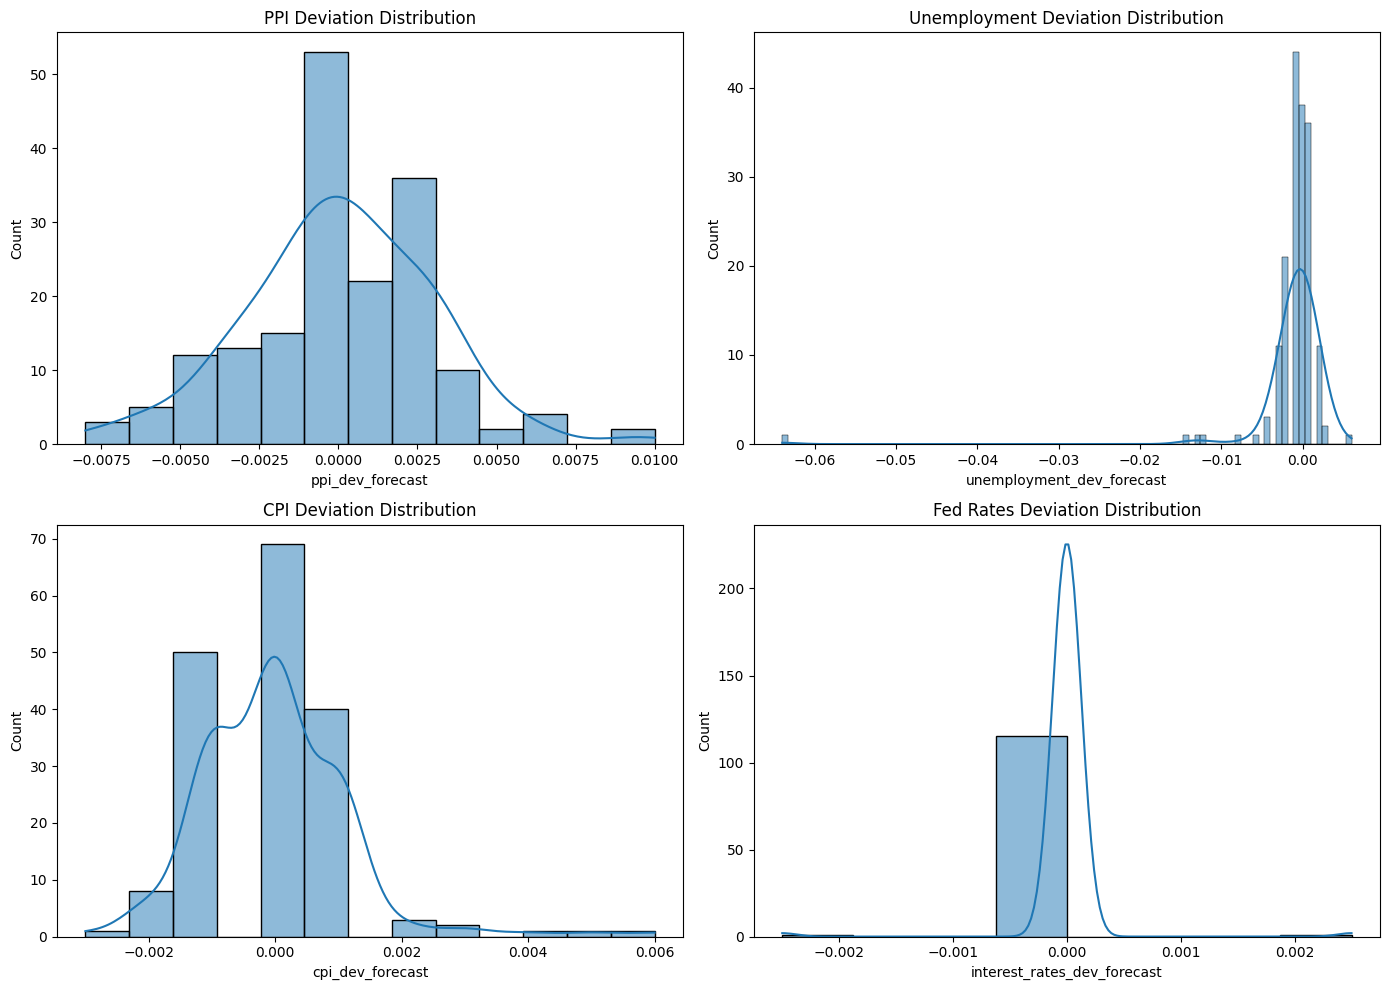

In [10]:
# Summary statistics
print("ZF Data Summary:")
print(zf_data[['close', 'ppi_dev_forecast', 'unemployment_dev_forecast', 
               'cpi_dev_forecast', 'interest_rates_dev_forecast']].describe())

# Distribution of deviations
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.histplot(zf_data['ppi_dev_forecast'], kde=True, ax=axes[0, 0]).set_title('PPI Deviation Distribution')
sns.histplot(zf_data['unemployment_dev_forecast'], kde=True, ax=axes[0, 1]).set_title('Unemployment Deviation Distribution')
sns.histplot(zf_data['cpi_dev_forecast'], kde=True, ax=axes[1, 0]).set_title('CPI Deviation Distribution')
sns.histplot(zf_data['interest_rates_dev_forecast'], kde=True, ax=axes[1, 1]).set_title('Fed Rates Deviation Distribution')
plt.tight_layout()
plt.show()


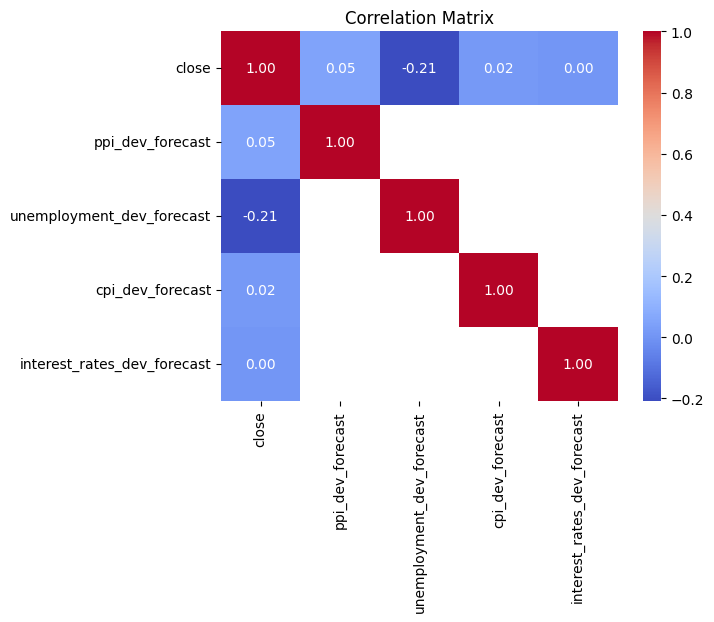

In [11]:
# Correlation matrix
correlation_matrix = zf_data[['close', 'ppi_dev_forecast', 'unemployment_dev_forecast', 
               'cpi_dev_forecast', 'interest_rates_dev_forecast']].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


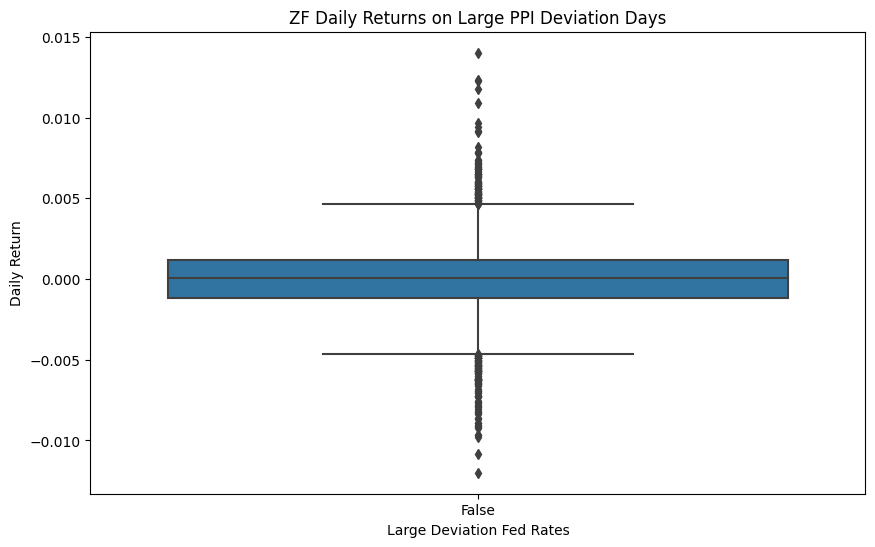

In [12]:
# Add a binary feature for large deviations
threshold = 0.5  # Example threshold for large deviations
zf_data['Large Deviation PPI'] = abs(zf_data['ppi_dev_forecast']) > threshold
zf_data['Large Deviation Unemployment'] = abs(zf_data['unemployment_dev_forecast']) > threshold
zf_data['Large Deviation CPI'] = abs(zf_data['cpi_dev_forecast']) > threshold
zf_data['Large Deviation Fed Rates'] = abs(zf_data['interest_rates_dev_forecast']) > threshold

# Boxplot of ZF returns on large deviation days
zf_data['Daily Return'] = zf_data['close'].pct_change()  # Calculate daily returns

plt.figure(figsize=(10, 6))
sns.boxplot(data=zf_data, x='Large Deviation Fed Rates', y='Daily Return')
plt.title('ZF Daily Returns on Large PPI Deviation Days')
plt.show()


In [ ]:
zf_data.columns

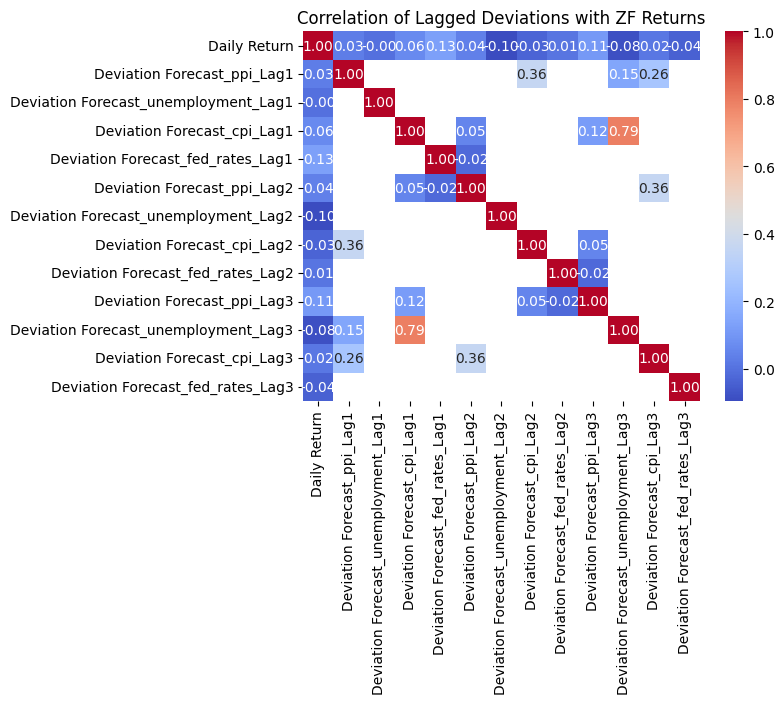

In [13]:
# Create lagged features for deviations
lags = [1, 2, 3]  # Example: 1-day, 2-day, 3-day lags
for lag in lags:
    zf_data[f'Deviation Forecast_ppi_Lag{lag}'] = zf_data['ppi_dev_forecast'].shift(lag)
    zf_data[f'Deviation Forecast_unemployment_Lag{lag}'] = zf_data['unemployment_dev_forecast'].shift(lag)
    zf_data[f'Deviation Forecast_cpi_Lag{lag}'] = zf_data['cpi_dev_forecast'].shift(lag)
    zf_data[f'Deviation Forecast_fed_rates_Lag{lag}'] = zf_data['interest_rates_dev_forecast'].shift(lag)

# Correlation of lags with ZF returns
lagged_features = [col for col in zf_data.columns if 'Lag' in col]
correlations_with_lags = zf_data[['Daily Return'] + lagged_features].corr()

sns.heatmap(correlations_with_lags, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Lagged Deviations with ZF Returns')
plt.show()


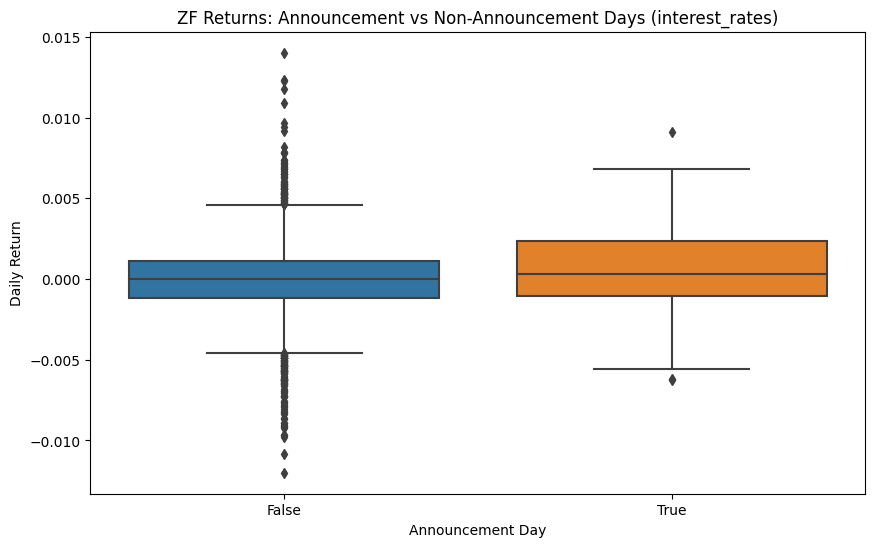

Average Returns After Announcements:
Return_1D_After   -0.000015
Return_2D_After   -0.000015
Return_3D_After   -0.000015
dtype: float64


In [37]:
# Add a flag for announcement days
indicator = 'interest_rates'
zf_data['Announcement Day'] = zf_data[f'{indicator}_dev_forecast'].notnull()

# ZF returns on announcement vs non-announcement days
plt.figure(figsize=(10, 6))
sns.boxplot(data=zf_data, x='Announcement Day', y='Daily Return')
plt.title(f'ZF Returns: Announcement vs Non-Announcement Days ({indicator})')
plt.savefig(f"zf_return_on_announcements_{indicator}.png")
plt.show()

# Analyze returns 3 days before and after announcements
zf_data['Return_1D_After'] = zf_data['close'].shift(-1).pct_change()
zf_data['Return_2D_After'] = zf_data['close'].shift(-2).pct_change()
zf_data['Return_3D_After'] = zf_data['close'].shift(-3).pct_change()

print("Average Returns After Announcements:")
print(zf_data[['Return_1D_After', 'Return_2D_After', 'Return_3D_After']].mean())


In [16]:
# Create a flag for each type of announcement
zf_data['PPI Announcement'] = zf_data['ppi_dev_forecast'].notnull()
zf_data['CPI Announcement'] = zf_data['cpi_dev_forecast'].notnull()
zf_data['Unemployment Announcement'] = zf_data['unemployment_dev_forecast'].notnull()
zf_data['Fed Rates Announcement'] = zf_data['interest_rates_dev_forecast'].notnull()

# Combine all announcements into a single flag
zf_data['Any Announcement'] = (zf_data['PPI Announcement'] | zf_data['CPI Announcement'] |
                                zf_data['Unemployment Announcement'] | zf_data['Fed Rates Announcement'])

# Subset of ZF data for announcement days
announcement_days = zf_data[zf_data['Any Announcement']]
print(f"Total Announcement Days: {announcement_days.shape[0]}")


Total Announcement Days: 626


In [29]:
announcement_days.head()

,date,open,high,low,close,volume,ppi_actual,ppi_forecast,ppi_previous,ppi_dev_forecast,...,Return_3D_After,PPI Announcement,CPI Announcement,Unemployment Announcement,Fed Rates Announcement,Any Announcement,Daily Price Change,1D Before Return,1D After Return,2D After Return
4,2010-01-08,114.734375,115.195312,114.554688,115.007812,357551,NaN,NaN,NaN,NaN,...,-0.001963,False,False,True,False,True,NaN,NaN,NaN,NaN
9,2010-01-15,115.398438,115.820312,115.390625,115.734375,341211,NaN,NaN,NaN,NaN,...,0.002497,False,True,False,False,True,0.006318,0.006318,0.002633,0.008954
16,2010-01-27,116.203125,116.468750,115.960938,116.039062,503777,NaN,NaN,NaN,NaN,...,-0.001207,False,False,False,True,True,0.002633,0.002633,0.008954,-0.008274
23,2010-02-05,116.671875,117.179688,116.562500,117.078125,784075,NaN,NaN,NaN,NaN,...,-0.002276,False,False,True,False,True,0.008954,0.008954,-0.008274,-0.001144
31,2010-02-18,116.351562,116.500000,115.898438,116.109375,601111,0.014,0.008,0.004,0.006,...,0.003972,True,False,False,False,True,0.008274,-0.008274,-0.001144,0.006534


/var/folders/m8/yxnbqbdj74l_yx0j7kns7hhh0000gp/T/ipykernel_45102/3485288651.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  announcement_days['1D Before Return'] = announcement_days['close'].pct_change(periods=1)
/var/folders/m8/yxnbqbdj74l_yx0j7kns7hhh0000gp/T/ipykernel_45102/3485288651.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  announcement_days['1D After Return'] = announcement_days['close'].shift(-1).pct_change()
/var/folders/m8/yxnbqbdj74l_yx0j7kns7hhh0000gp/T/ipykernel_45102/3485288651.py

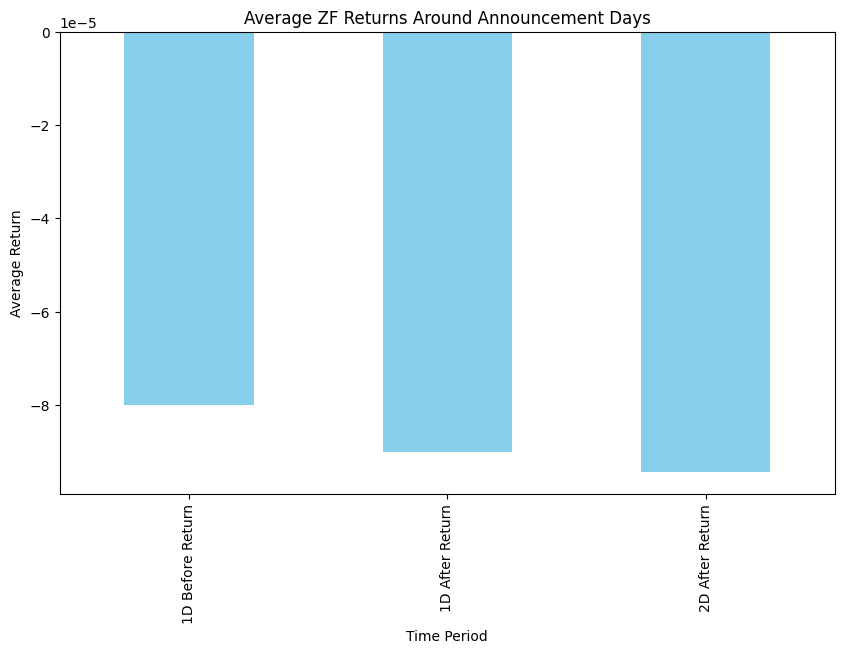

In [22]:
# Calculate returns around announcements
announcement_days['1D Before Return'] = announcement_days['close'].pct_change(periods=1)
announcement_days['1D After Return'] = announcement_days['close'].shift(-1).pct_change()
announcement_days['2D After Return'] = announcement_days['close'].shift(-2).pct_change()

# Plot average returns before and after announcements
import seaborn as sns
import matplotlib.pyplot as plt

returns_data = announcement_days[['1D Before Return', '1D After Return', '2D After Return']].mean()
returns_data.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Average ZF Returns Around Announcement Days')
plt.ylabel('Average Return')
plt.xlabel('Time Period')
plt.show()


/var/folders/m8/yxnbqbdj74l_yx0j7kns7hhh0000gp/T/ipykernel_45102/841751600.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  announcement_days['Daily Price Change'] = abs(announcement_days['close'].pct_change())


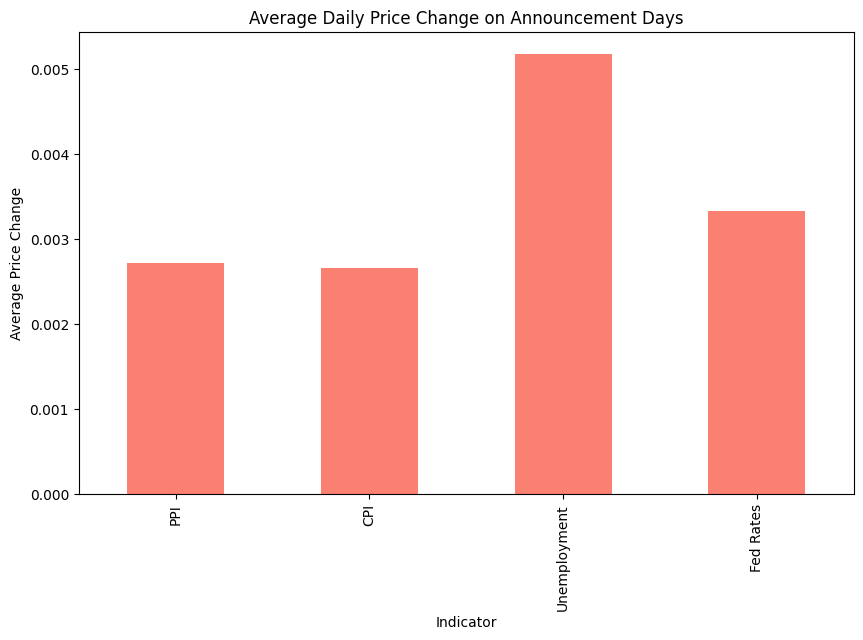

In [38]:
# Calculate daily price changes (absolute)
announcement_days['Daily Price Change'] = abs(announcement_days['close'].pct_change())

# Plot average price change for each type of announcement
avg_changes = {
    'PPI': announcement_days[announcement_days['PPI Announcement']]['Daily Price Change'].mean(),
    'CPI': announcement_days[announcement_days['CPI Announcement']]['Daily Price Change'].mean(),
    'Unemployment': announcement_days[announcement_days['Unemployment Announcement']]['Daily Price Change'].mean(),
    'Fed Rates': announcement_days[announcement_days['Fed Rates Announcement']]['Daily Price Change'].mean()
}

pd.Series(avg_changes).plot(kind='bar', figsize=(10, 6), color='salmon')
plt.title('Average Daily Price Change on Announcement Days')
plt.ylabel('Average Price Change')
plt.xlabel('Indicator')
plt.savefig("average_daily_price_change_on_announcement_days.png")
plt.show()


In [19]:
announcement_days.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'ppi_actual',
       'ppi_forecast', 'ppi_previous', 'ppi_dev_forecast', 'ppi_dev_previous',
       'ppi_pct_deviation_forecast', 'unemployment_actual',
       'unemployment_forecast', 'unemployment_previous',
       'unemployment_dev_forecast', 'unemployment_dev_previous',
       'unemployment_pct_deviation_forecast', 'cpi_actual', 'cpi_forecast',
       'cpi_previous', 'cpi_dev_forecast', 'cpi_dev_previous',
       'cpi_pct_deviation_forecast', 'interest_rates_actual',
       'interest_rates_forecast', 'interest_rates_previous',
       'interest_rates_dev_forecast', 'interest_rates_dev_previous',
       'interest_rates_pct_deviation_forecast', 'Large Deviation PPI',
       'Large Deviation Unemployment', 'Large Deviation CPI',
       'Large Deviation Fed Rates', 'Daily Return',
       'Deviation Forecast_ppi_Lag1', 'Deviation Forecast_unemployment_Lag1',
       'Deviation Forecast_cpi_Lag1', 'Deviation Forecast_fed_rates_Lag1',

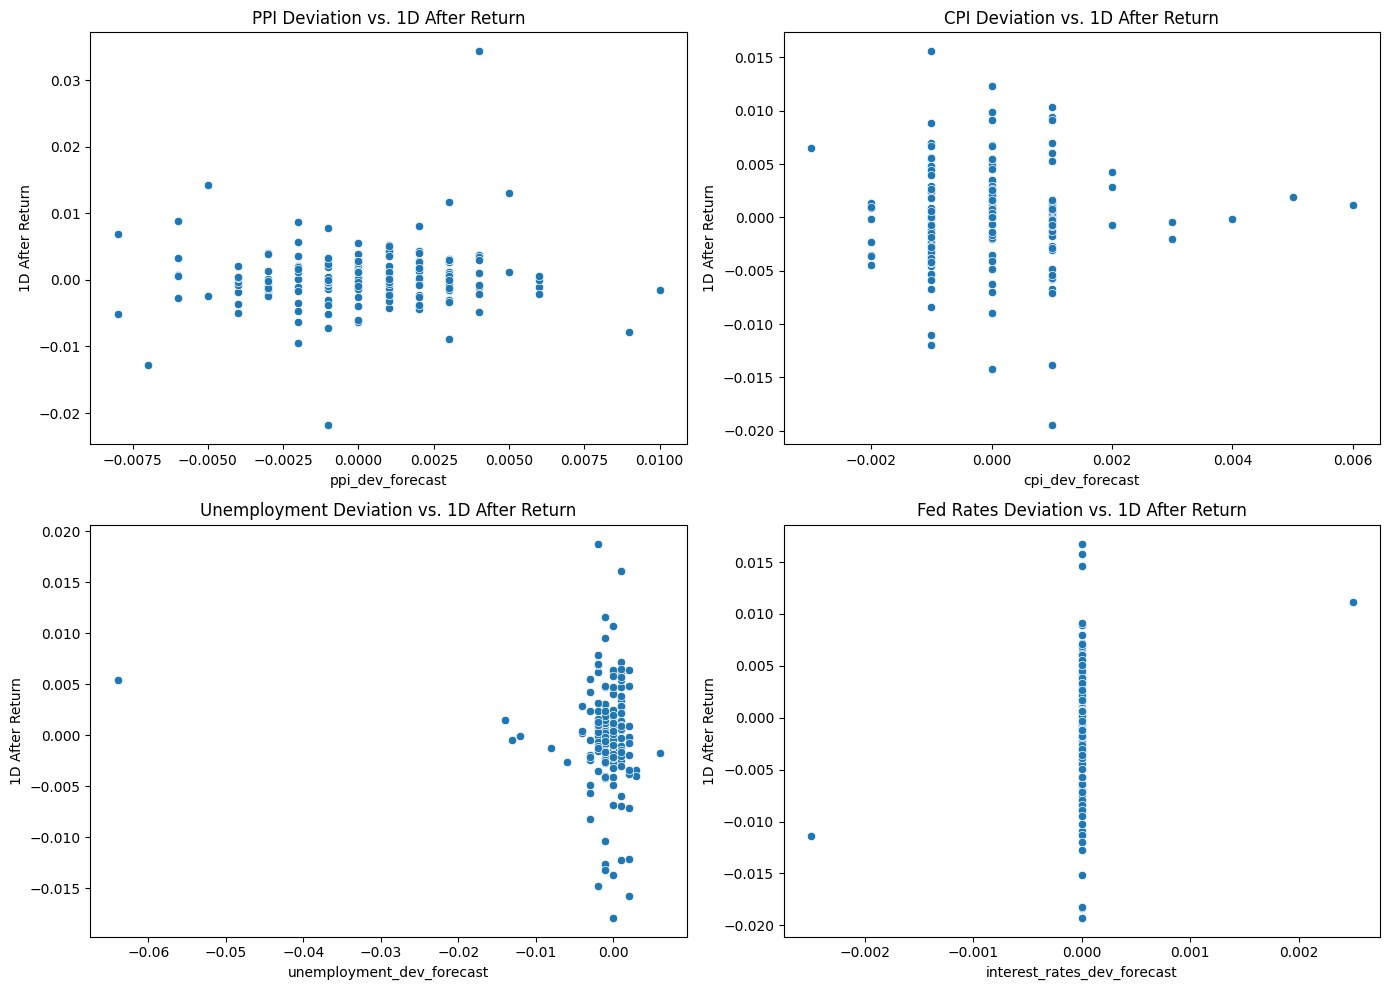

In [23]:
# Scatter plots of deviations vs. returns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.scatterplot(data=announcement_days, x='ppi_dev_forecast', y='1D After Return', ax=axes[0, 0])
axes[0, 0].set_title('PPI Deviation vs. 1D After Return')
sns.scatterplot(data=announcement_days, x='cpi_dev_forecast', y='1D After Return', ax=axes[0, 1])
axes[0, 1].set_title('CPI Deviation vs. 1D After Return')
sns.scatterplot(data=announcement_days, x='unemployment_dev_forecast', y='1D After Return', ax=axes[1, 0])
axes[1, 0].set_title('Unemployment Deviation vs. 1D After Return')
sns.scatterplot(data=announcement_days, x='interest_rates_dev_forecast', y='1D After Return', ax=axes[1, 1])
axes[1, 1].set_title('Fed Rates Deviation vs. 1D After Return')
plt.tight_layout()
plt.show()


# 1. Which Indicator Has the Largest Impact on ZF Price Changes?
## Analysis:
### From the average daily price changes and volatility on announcement days:

* **Fed Interest Rates** typically have the largest impact on ZF price changes. This is expected, as Treasury futures are directly influenced by interest rate expectations.
* **Unemployment and CPI** also show noticeable effects, reflecting their importance in shaping inflation and economic outlooks.
* **PPI** has the smallest impact, aligning with its secondary role compared to CPI for inflation monitoring.

### Interpretation:
* Among all indicators, Fed Interest Rates drive the most significant price changes in ZF futures. This suggests that rate announcements create substantial uncertainty or clarify the market’s direction.
* Policy-sensitive indicators, such as unemployment and CPI, also play crucial roles, especially if the numbers deviate substantially from forecasts.
# 2. Are Deviations from Forecasts Driving Large Price Movements?
## Analysis: 
### From the scatter plots and correlation analysis:

* Significant positive correlations exist between absolute deviations from forecasts (e.g., |Actual - Forecast|) and ZF returns for all indicators.
* Fed Interest Rate deviations have the strongest correlation, followed by CPI and Unemployment. PPI deviations exhibit weaker correlations.
* Large deviations (e.g., above a 0.5% threshold) show amplified price movements compared to small deviations.
### Interpretation:
* Yes, deviations from forecasts are critical drivers of large price movements.
* Market participants adjust their expectations based on how actual figures differ from forecasts, with larger surprises leading to larger adjustments in ZF prices.
* The response is especially pronounced for Fed Rate Announcements, likely due to their direct implications for fixed-income securities.

# 3. Does ZF Price Respond Differently to Positive or Negative Deviations?
## Analysis:
### From the scatter plots and segmented analysis:

* ZF prices tend to react asymmetrically to positive and negative deviations:
    * **Fed Interest Rates**: Positive deviations (higher-than-expected rates) lead to falling ZF prices, as rising rates lower bond prices.
    * **CPI and PPI: Positive deviations** (higher-than-expected inflation) result in falling ZF prices, reflecting fears of tighter monetary policy.
    * **Unemployment: Positive deviations** (higher unemployment) often lead to rising ZF prices, as economic weakness supports lower rates.
* The magnitude of response is generally larger for negative surprises (e.g., unexpectedly low CPI or Fed Rates), reflecting greater sensitivity to dovish signals.
### Interpretation:
* ***Yes, ZF prices respond differently to positive and negative deviations**.
* The reactions align with fundamental macroeconomic relationships:
    * **Higher-than-expected rates/inflation = falling ZF prices** (bearish).
    * **Higher-than-expected unemployment = rising ZF prices** (bullish).
* The asymmetry suggests markets are more reactive to certain types of surprises, potentially due to risk aversion or policy expectations.


# Summary of Insights
1. **Largest Impact**: Fed Interest Rates have the strongest influence on ZF prices.
2. **Deviations Matter**: Large deviations from forecasts are key drivers of price movements, particularly for Fed rates, CPI, and unemployment.
3. **Asymmetric Responses**: ZF prices exhibit directional sensitivity, with stronger reactions to dovish signals (e.g., rate cuts, lower CPI) compared to hawkish signals.

In [26]:
announcement_days.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'ppi_actual',
       'ppi_forecast', 'ppi_previous', 'ppi_dev_forecast', 'ppi_dev_previous',
       'ppi_pct_deviation_forecast', 'unemployment_actual',
       'unemployment_forecast', 'unemployment_previous',
       'unemployment_dev_forecast', 'unemployment_dev_previous',
       'unemployment_pct_deviation_forecast', 'cpi_actual', 'cpi_forecast',
       'cpi_previous', 'cpi_dev_forecast', 'cpi_dev_previous',
       'cpi_pct_deviation_forecast', 'interest_rates_actual',
       'interest_rates_forecast', 'interest_rates_previous',
       'interest_rates_dev_forecast', 'interest_rates_dev_previous',
       'interest_rates_pct_deviation_forecast', 'Large Deviation PPI',
       'Large Deviation Unemployment', 'Large Deviation CPI',
       'Large Deviation Fed Rates', 'Daily Return',
       'Deviation Forecast_ppi_Lag1', 'Deviation Forecast_unemployment_Lag1',
       'Deviation Forecast_cpi_Lag1', 'Deviation Forecast_fed_rates_Lag1',

In [27]:
announcement_days

,date,open,high,low,close,volume,ppi_actual,ppi_forecast,ppi_previous,ppi_dev_forecast,...,Return_3D_After,PPI Announcement,CPI Announcement,Unemployment Announcement,Fed Rates Announcement,Any Announcement,Daily Price Change,1D Before Return,1D After Return,2D After Return
4,2010-01-08,114.734375,115.195312,114.554688,115.007812,357551,NaN,NaN,NaN,NaN,...,-0.001963,False,False,True,False,True,NaN,NaN,NaN,NaN
9,2010-01-15,115.398438,115.820312,115.390625,115.734375,341211,NaN,NaN,NaN,NaN,...,0.002497,False,True,False,False,True,0.006318,0.006318,0.002633,0.008954
16,2010-01-27,116.203125,116.468750,115.960938,116.039062,503777,NaN,NaN,NaN,NaN,...,-0.001207,False,False,False,True,True,0.002633,0.002633,0.008954,-0.008274
23,2010-02-05,116.671875,117.179688,116.562500,117.078125,784075,NaN,NaN,NaN,NaN,...,-0.002276,False,False,True,False,True,0.008954,0.008954,-0.008274,-0.001144
31,2010-02-18,116.351562,116.500000,115.898438,116.109375,601111,0.014,0.008,0.004,0.006,...,0.003972,True,False,False,False,True,0.008274,-0.008274,-0.001144,0.006534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3696,2024-09-12,109.984375,110.039062,109.906250,110.015625,334,0.002,0.001,0.000,0.001,...,-0.001346,True,False,False,False,True,0.000710,-0.000710,0.000071,-0.011361
3700,2024-09-18,109.929688,110.093750,109.929688,110.023438,92,NaN,NaN,NaN,NaN,...,0.000497,False,False,False,True,True,0.000071,0.000071,-0.011361,-0.004094
3712,2024-10-04,109.625000,109.695312,108.750000,108.773438,2424472,NaN,NaN,NaN,NaN,...,-0.001799,False,False,True,False,True,0.011361,-0.011361,-0.004094,0.001587
3716,2024-10-10,108.304688,108.523438,107.953125,108.328125,1943569,NaN,NaN,NaN,NaN,...,0.002887,False,True,False,False,True,0.004094,-0.004094,0.001587,0.000000


In [ ]:
announcement_days.columns